In [ ]:
# Reliable XAI (RF+SHAP) — compact version
import os, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

# -------------------- tiny utils --------------------
def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s); np.random.seed(s); os.environ["PYTHONHASHSEED"]=str(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad: X.drop(columns=bad, inplace=True)
    if X.isna().any().any(): X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    """Collapse SHAP values to 1-D importance vector of len=n_features."""
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv)>=2 else sv[0])
    else:
        arr = np.asarray(sv)
    if arr.ndim==2 and arr.shape[1]==n_features:
        return np.abs(arr).mean(axis=0)
    feat_axes = [ax for ax,d in enumerate(arr.shape) if d==n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim-1)))
    return np.abs(arr.reshape(-1, n_features)).mean(axis=0)

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a,b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5*(rho+1)

# -------------------- config --------------------
@dataclass
class PipelineConfig:
    data_path: str = "./../dataset/CM1.csv"
    target_col: str = "Defective"
    rng: int = 42
    n_splits: int = 5
    use_smote: bool = True
    smote_k_max: int = 5
    # RF
    rf_n_estimators: int = 1600
    rf_max_depth: Optional[int] = 10
    rf_min_samples_leaf: int = 3
    # SHAP
    shap_background_size: int = 1024
    shap_eval_size: int = 10_000  # effectively "all" for small sets
    shap_nsamples: int = 600
    # Concordance
    perm_repeats: int = 40
    concordance_top_k: int = 25

# -------------------- data loader --------------------
def load_or_synthesize(cfg: PipelineConfig, allow_synth: bool=False) -> Tuple[pd.DataFrame, pd.Series]:
    p,tgt = cfg.data_path, cfg.target_col
    if os.path.exists(p):
        def clean(df):
            drop=[c for c in df.columns if str(c).strip().lower().startswith("unnamed:")]
            return df.drop(columns=drop) if drop else df
        try:
            df = clean(pd.read_csv(p))
            if tgt in df.columns:
                return df.drop(columns=[tgt]).copy(), df[tgt].astype(int).copy()
        except Exception: pass
        df = pd.read_csv(p, header=None)
        hdr = df.iloc[0].astype(str).tolist()
        if len(set(hdr))==len(hdr):
            df2 = df.iloc[1:].copy(); df2.columns = hdr; df2 = clean(df2)
            if tgt in df2.columns:
                return df2.drop(columns=[tgt]).copy(), df2[tgt].astype(int).copy()
        df.columns=[f"col_{i}" for i in range(df.shape[1])]
        raise ValueError(f"Target '{tgt}' not found in {p}.")
    if not allow_synth: raise FileNotFoundError(p)
    n,p = 1200, 25
    X = pd.DataFrame(np.random.randn(n,p), columns=[f"f{i}" for i in range(p)])
    logits = 1.5*X["f1"] - 1.2*X["f3"] + 0.8*X["f5"] + 0.6*(X["f2"]*X["f4"])
    y = (np.random.rand(n) < 1/(1+np.exp(-logits))).astype(int)
    return X, pd.Series(y, name="y")

# -------------------- RF + SHAP --------------------
class RFModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg
        self.model = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=True
        )
        self._cols: List[str] = []

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(X[self._cols])

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        cols = self._cols
        X_bg, X_eval = X_bg[cols], X_eval[cols]
        rng = np.random.RandomState(0)
        bg = X_bg.iloc[rng.choice(len(X_bg), size=min(len(X_bg), self.cfg.shap_background_size), replace=False)]
        sample = X_eval if len(X_eval) <= self.cfg.shap_eval_size \
                 else X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]
        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="interventional")
            sv = expl.shap_values(sample)
        except Exception:
            expl = shap.KernelExplainer(self.model.predict_proba, bg, link="logit")
            sv = expl.shap_values(sample, nsamples=self.cfg.shap_nsamples)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

    def permutation_importance_stable(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        """Rank-normalized, multi-repeat permutation importance (AUC-drop)."""
        cols = self._cols; nrep = self.cfg.perm_repeats
        rng0 = np.random.RandomState(1)
        base_auc = roc_auc_score(y, self.predict_proba(X)[:,1])
        rsum = np.zeros(len(cols))
        for r in range(nrep):
            rng = np.random.RandomState(rng0.randint(1_000_000))
            deltas = []
            for c in cols:
                Xp = X.copy()
                Xp[c] = rng.permutation(Xp[c].values)
                auc_p = roc_auc_score(y, self.predict_proba(Xp)[:,1])
                deltas.append(max(base_auc - auc_p, 0.0))
            ranks = pd.Series(deltas, index=cols).rank(pct=True)   # 0..1
            rsum += ranks.values
        return pd.Series(rsum/nrep, index=cols, name="perm_rank")

# -------------------- reliability k-fold --------------------
def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig):
    set_seed(cfg.rng); X = drop_constant_and_fillna(X)
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)

    tA,tF,tP,tR, A,F,P,R = [],[],[],[], [],[],[], []
    expl_tr, expl_te, rows = [], [], []

    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        seed = cfg.rng + fold; set_seed(seed)
        Xtr,Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr,yte = y.iloc[tr].copy(), y.iloc[te].copy()
        Xfit,yfit = Xtr,ytr
        if cfg.use_smote:
            try:
                minority = int((ytr==1).sum()); k = min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception: pass

        model = RFModel(cfg, random_state=seed).fit(Xfit,yfit)

        p_tr = model.predict_proba(Xtr)[:,1]; yhat_tr = (p_tr>=0.5).astype(int)
        tA.append(roc_auc_score(ytr,p_tr)); tF.append(f1_score(ytr,yhat_tr))
        tP.append(precision_score(ytr,yhat_tr, zero_division=0)); tR.append(recall_score(ytr,yhat_tr))

        p_te = model.predict_proba(Xte)[:,1]; yhat_te = (p_te>=0.5).astype(int)
        A.append(roc_auc_score(yte,p_te)); F.append(f1_score(yte,yhat_te))
        P.append(precision_score(yte,yhat_te, zero_division=0)); R.append(recall_score(yte,yhat_te))

        gtr = model.shap_importance(Xfit, Xtr)
        gte = model.shap_importance(Xfit, Xte)
        expl_tr.append(gtr); expl_te.append(gte)

        perm_rank = model.permutation_importance_stable(Xte, yte)     # rank-normalized
        gte_r, perm_r = gte.rank(pct=True), perm_rank.rank(pct=True)  # same scale

        K = min(cfg.concordance_top_k, len(gte_r))
        top = list(set(gte_r.sort_values(ascending=False).head(K).index) &
                   set(perm_r.sort_values(ascending=False).head(K).index))
        concord = spearman_rank_corr(gte_r.loc[top], perm_r.loc[top]) if top else np.nan

        rows.append({
            "fold": fold,
            "Train_AUC": tA[-1], "Train_F1": tF[-1], "Train_Precision": tP[-1], "Train_Recall": tR[-1],
            "AUC": A[-1], "F1": F[-1], "Precision": P[-1], "Recall": R[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": concord
        })

    perfold = pd.DataFrame(rows)

    # Stability across TEST explanations (less leakage)
    def _mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        if len(series_list)<2: return np.nan
        vals=[spearman_rank_corr(series_list[i], series_list[j])
              for i in range(len(series_list)) for j in range(i+1,len(series_list))]
        return float(np.nanmean(vals))
    stability = _mean_pairwise_spearman(expl_te)

    gap = float(np.mean(tA)) - float(np.mean(A))
    ri = float(np.nanmean([
        rescale01_rho(perfold["Generalizability"].mean()),
        rescale01_rho(perfold["Concordance"].mean()),
        rescale01_rho(stability)
    ]))

    summary = pd.DataFrame([{
        "Model": "random_forest",
        "Train_AUC_mean": float(np.mean(tA)), "AUC_mean": float(np.mean(A)),
        "F1_mean": float(np.mean(F)), "Precision_mean": float(np.mean(P)), "Recall_mean": float(np.mean(R)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability), "ReliabilityIndex": ri, "OverfitGap": gap
    }])

    mean_imp = pd.concat(expl_te, axis=1)
    mean_imp.columns = [f"fold{i+1}" for i in range(mean_imp.shape[1])]
    mean_imp = mean_imp.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}

# -------------------- plotting --------------------
def plot_topk(importance: pd.Series, top_k=10, title=None, original_feature_names: Optional[List[str]]=None):
    if importance is None or importance.empty: return
    imp = importance.copy()
    if original_feature_names is not None: imp.index = [str(i) for i in imp.index]
    topN = imp.sort_values(ascending=False).head(min(top_k, len(imp)))
    y = np.arange(len(topN))
    plt.figure(figsize=(9, max(4, 0.5*len(topN))))
    plt.barh(y, topN.values); plt.yticks(y, topN.index)
    plt.gca().invert_yaxis(); plt.xlabel("importance")
    plt.title(title or f"Top {len(topN)} — RANDOM_FOREST (SHAP)"); plt.tight_layout(); plt.show()

# -------------------- one-call runner --------------------
def run_pipeline_with_plot(
    *, data_path: str, target_col: str = "Defective", top_k: int = 10,
    n_splits: int = 5, use_smote: bool = True, cfg_overrides: Optional[Dict]=None, show_plot: bool = True
):
    cfg = PipelineConfig(data_path=data_path, target_col=target_col, n_splits=n_splits, use_smote=use_smote)
    if cfg_overrides:
        for k,v in cfg_overrides.items():
            if hasattr(cfg,k): setattr(cfg,k,v)
            else: raise KeyError(f"Invalid override: {k}")
    set_seed(cfg.rng)
    X,y = load_or_synthesize(cfg)
    df_cls, arts = run_reliability_kfold(X,y,cfg)
    try:
        from IPython.display import display; display(df_cls.round(4))
    except Exception: print(df_cls.round(4))
    if show_plot:
        plot_topk(arts["mean_importance_test"], top_k=top_k, original_feature_names=list(X.columns))
    return df_cls, arts


 98%|===================| 513/524 [00:33<00:00]        

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9976,0.7379,0.2335,0.256,0.2694,0.985,0.4655,0.8023,0.8755,0.2598


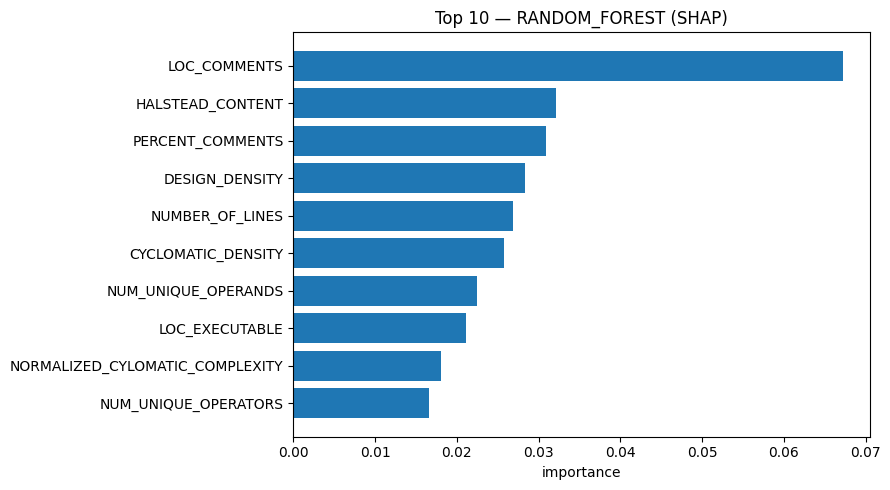

In [ ]:
df_cls, arts = run_pipeline_with_plot(
    data_path="./../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    n_splits=5,
    use_smote=True,
    cfg_overrides=dict(
        perm_repeats=60,
        concordance_top_k=30,
        rf_n_estimators=2000
    ),
    show_plot=True,
)